### Import the Relevants Packages

In [1]:
import selectivesearch
import cv2
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Dataset
from torchvision.ops import nms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch_snippets import *
import warnings
warnings.filterwarnings("ignore")

### Preparing the Dataset

In [2]:
df = pd.read_csv('df.csv')
images_root = 'images/'
df.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,...,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,...,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,...,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,...,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,...,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452


In [3]:
class ImageDataset(Dataset):
    def __init__(self , df , images_root):
        self.df = df
        self.images_root = images_root
        self.unique_images = df['ImageID'].unique()
    
    def __len__(self):
        return len(self.unique_images)
    
    def __getitem__(self , idx):
        image_id = self.unique_images[idx]
        image_path = f'{self.images_root}/{image_id}.jpg'
        image = cv2.imread(image_path, 1)[:, :, ::-1]
        heigth , width , _ = image.shape
        df = self.df.copy()
        df = df[df['ImageID'] == image_id]
        boxes = df['XMin,YMin,XMax,YMax'.split(',')].values
        boxes = (boxes * np.array([width , heigth , width , heigth])).astype(np.int16).tolist()
        classes = df['LabelName'].values.tolist()
        return image , boxes , classes, image_path
        

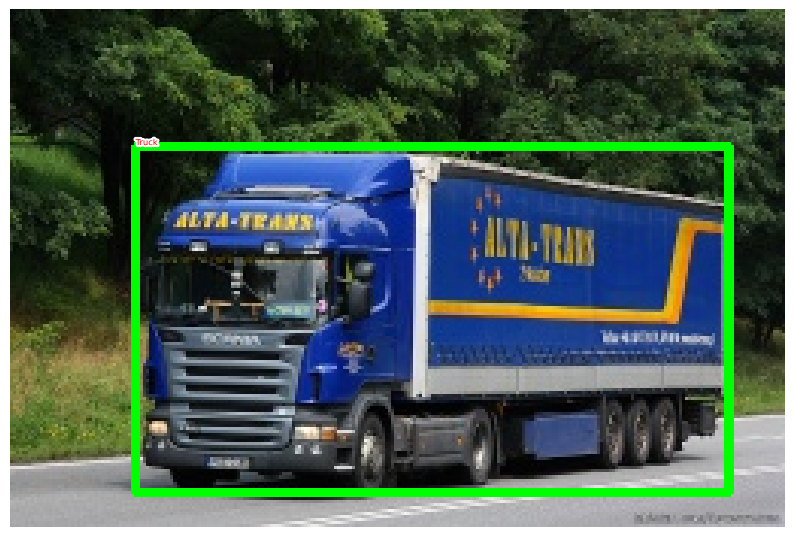

In [4]:
images_dataset = ImageDataset(df , images_root)
image, box, label, _ = images_dataset[9]
show(image, bbs=box, texts=label, sz=10)

In [5]:
def extract_candidates(image):

    image_label, regions = selectivesearch.selective_search(image, scale=200, min_size=100)
    image_area = np.prod(image.shape[:2])
    candidates = []
    for r in regions:
        if r['rect'] in candidates:continue
        if r['size'] < (0.05 * image_area): continue
        if r['size'] > (1 * image_area):continue
        x, y, w, h = r['rect']
        if w == 0 or h == 0:
            continue
        candidates.append(list(r['rect']))

    return candidates

def extract_iou(boxA,boxB, epsilon):
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    width = (x2 - x1)
    height = (y2 - y1)
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap
    iou = area_overlap / (area_combined+epsilon)
    return iou


### Fetching Region Proposals and the Ground Truth of Offset

In [6]:
FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [],[],[],[],[],[]
for ix, (image , boxes , classes, image_path) in enumerate(images_dataset):
    H, W, _ = image.shape
    candidates = extract_candidates(image)
    candidates = np.array([(x, y, x+w, y+h) for x, y, w, h in candidates])
    ious, rois, clss, deltas = [], [], [], []
    ious = np.array([[extract_iou(candidate, _bb_, 1e-6 ) for candidate in candidates] for _bb_ in boxes]).T

    for jx, candidate in enumerate(candidates):
        cx,cy, cX,cY = candidate
        candidate_ious = ious[jx]
        best_iou_at = np.argmax(candidate_ious)
        best_iou = candidate_ious[best_iou_at]
        best_bb = _x,_y,_X,_Y = boxes[best_iou_at]
        if best_iou > 0.3: clss.append(classes[best_iou_at])
        else: clss.append('background')

        delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) / np.array([W,H,W,H])
        deltas.append(delta)
        rois.append(candidate/np.array([W,H,W,H]))
    
    FPATHS.append(image_path)
    IOUS.append(ious)
    ROIS.append(rois)
    CLSS.append(classes)
    DELTAS.append(deltas)
    GTBBS.append(boxes)

    

In [21]:
FPATHS = [f'{images_root}/{stem(f)}.jpg' for f in FPATHS]
FPATHS, GTBBS, CLSS, DELTAS, ROIS = [item for item in [FPATHS, GTBBS, CLSS, DELTAS, ROIS]]
targets = pd.DataFrame(flatten(CLSS), columns=['label'])
label2target = {l:t for t,l in enumerate(targets['label'].unique())}
target2label = {t:l for l,t in label2target.items()}

### Creating the Training Data

In [9]:
normalize= transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

In [28]:
def preprocess_image(image):
    image = torch.tensor(image).permute(2,0,1)
    image = normalize(image)
    return image.to(device).float()

In [29]:
def decode(_y):
    _, preds = _y.max(-1)
    
    return preds

In [30]:
class RCNNDataset(Dataset):
    def __init__(self, fpaths, rois, labels, deltas, gtbbs):
        self.fpaths = fpaths
        self.gtbbs = gtbbs
        self.rois = rois
        self.labels = labels
        self.deltas = deltas

    def __len__(self): return len(self.fpaths)

    def __getitem__(self, ix) :

        fpath = str(self.fpaths[ix])
        image = cv2.imread(fpath, 1)[...,::-1]
        H, W, _ = image.shape
        sh = np.array([W,H,W,H])
        gtbbs = self.gtbbs[ix]
        rois = self.rois[ix]
        bbs = (np.array(rois)*sh).astype(np.uint16)
        labels = self.labels[ix]
        deltas = self.deltas[ix]
        crops = [image[y:Y,x:X] for (x,y,X,Y) in bbs]

        return image,crops,bbs,labels,deltas,gtbbs,fpath
    
    def collate_fn(self, batch):
        input, rois, rixs, labels, deltas =[],[],[],[],[]
        for ix in range(len(batch)):
            image, crops, image_bbs, image_labels, image_deltas, image_gt_bbs, image_fpath = batch[ix]

            crops = [cv2.resize(crop, (224,224)) for crop in crops]
            crops = [preprocess_image(crop/255.)[None] for crop in crops]
            input.extend(crops)
            labels.extend([label2target[c] for c in image_labels])
            deltas.extend(image_deltas)
            input = torch.cat(input).to(device)
            labels = torch.Tensor(labels).long().to(device)
            deltas = torch.Tensor(deltas).float().to(device)
            
            return input, labels, deltas

In [31]:
n_train = 9*len(FPATHS)//10
train_ds = RCNNDataset(FPATHS[:n_train], ROIS[:n_train], CLSS[:n_train], DELTAS[:n_train], GTBBS[:n_train])
test_ds = RCNNDataset(FPATHS[n_train:], ROIS[n_train:], CLSS[n_train:], DELTAS[n_train:], GTBBS[n_train:])

In [32]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_ds, batch_size=2, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2, collate_fn=test_ds.collate_fn, drop_last=True)